In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from math import radians, degrees
import os
from shapely import wkt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

from sklearn.preprocessing import scale
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances, euclidean_distances

# Read data

In [2]:
data_dir = '../data'
education = pd.read_csv(os.path.join(data_dir, 'Education_ForModelling.csv'), index_col=0)
education.shape

(2660, 82)

In [3]:
#Function to display at most 1000 rows and at most 1000 columns
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
# Change df to geodataframe
education['geometry'] = education['geometry'].apply(wkt.loads)
education = gpd.GeoDataFrame(education, geometry='geometry')

<AxesSubplot:>

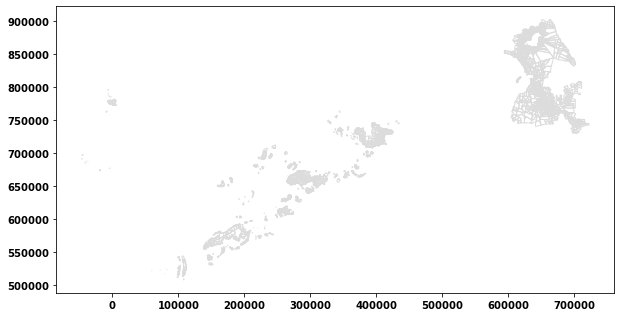

In [5]:
# Read barangay-level admin boundaries from shp file
brgy_dir = '../data/Administrative Boundaries - BARMM Barangays ao 20190206 (PSA 2016)'
brgy_file = 'AdministrativeBoundariesBARMMBarangays20190206PSA2016.shp'
brgy_bounds = gpd.read_file(os.path.join(brgy_dir, brgy_file))

# Visualize bounds
brgy_bounds['geometry'].plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3)

In [6]:
# Add the centroid of each city / municipality
brgy_bounds['centroid'] = brgy_bounds['geometry'].centroid

# Change coordinate reference system to 4326 (lat/long)
brgy_bounds['geometry'] = brgy_bounds['geometry'].to_crs(epsg=4326)
brgy_bounds['centroid'] = brgy_bounds['centroid'].to_crs(epsg=4326)

brgy_bounds['lon'] = brgy_bounds['centroid'].x
brgy_bounds['lat'] = brgy_bounds['centroid'].y
display_all(brgy_bounds.head())

,Reg_Code,Reg_Name,Pro_Code,Pro_Name,Mun_Code,Mun_Name,Bgy_Code,Bgy_Name,geometry,centroid,lon,lat
0,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001001,Balimbing Proper,"MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...",POINT (119.96552 5.09753),119.965518,5.097532
1,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001002,Batu-batu (Pob.),"POLYGON ((119.88709 5.06919, 119.88709 5.06920...",POINT (119.88302 5.09129),119.883020,5.091289
2,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001003,Buan,"MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...",POINT (120.00070 5.15760),120.000703,5.157595
3,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001004,Dungon,"POLYGON ((120.13585 5.19601, 120.13584 5.19603...",POINT (120.12350 5.21772),120.123501,5.217723
4,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001005,Luuk Buntal,"MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...",POINT (120.00454 4.98161),120.004538,4.981608


In [7]:
schools = education[['SCH_NAME',
                    'PSGC_BRGY',
                    'PSGC_MUNI',
                    'PSGC_PROV',
                    'LAT',
                    'LONG',
                    'geometry']]
schools.head()

,SCH_NAME,PSGC_BRGY,PSGC_MUNI,PSGC_PROV,LAT,LONG,geometry
0,Abong-Abong ES,PH150704001,PH150704000,PH150700000,6.507703,121.910937,POINT (121.91094 6.50770)
1,Akbar ES,PH150708008,PH150708000,PH150700000,6.664125,122.195725,POINT (122.19572 6.66413)
2,Amaloy ES,PH150711001,PH150711000,PH150700000,6.443614,122.126717,POINT (122.12672 6.44361)
3,Atong-Atong ES,PH150703001,PH150703000,PH150700000,6.660000,121.899633,POINT (121.89963 6.66000)
4,Babag ES,PH150713001,PH150713000,PH150700000,6.342007,121.954045,POINT (121.95404 6.34201)


In [8]:
# Keep only one record for each brgy
brgy_info = education[['PSGC_BRGY',
        'PSGC_MUNI',
        'PSGC_PROV',
        'CES_SCH_BRGY',
        'ES_SCH_BRGY',
        'JHS_SCH_BRGY',
        'MD_SCH_BRGY',
        'PES_SCH_BRGY',
        'PJHS_SCH_BRGY',
        'PS_SCH_BRGY',
        'PSHS_SCH_BRGY',
        'SHS_SCH_BRGY',
        'SUC_SCH_BRGY',
        'BRGY_SCHOOLS',
        'brgy_area',
        'Total_under10',
        'Total_10to20',
        'Total_31to60']].drop_duplicates(subset='PSGC_BRGY', keep='first')

brgy_info.head()

,PSGC_BRGY,PSGC_MUNI,PSGC_PROV,CES_SCH_BRGY,ES_SCH_BRGY,JHS_SCH_BRGY,MD_SCH_BRGY,PES_SCH_BRGY,PJHS_SCH_BRGY,PS_SCH_BRGY,PSHS_SCH_BRGY,SHS_SCH_BRGY,SUC_SCH_BRGY,BRGY_SCHOOLS,brgy_area,Total_under10,Total_10to20,Total_31to60
0,PH150704001,PH150704000,PH150700000,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4.590691,297.0,245.0,222.0
1,PH150708008,PH150708000,PH150700000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1.797243,300.0,303.0,308.0
2,PH150711001,PH150711000,PH150700000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.478142,329.0,284.0,318.0
3,PH150703001,PH150703000,PH150700000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,5.649323,594.0,621.0,661.0
4,PH150713001,PH150713000,PH150700000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2.570479,569.0,768.0,469.0


In [9]:
brgy_df = brgy_bounds[['Bgy_Code', 'geometry', 'centroid', 'lon', 'lat']].merge(brgy_info, how='left', left_on='Bgy_Code', right_on='PSGC_BRGY')
brgy_df.head()

,Bgy_Code,geometry,centroid,lon,lat,PSGC_BRGY,PSGC_MUNI,PSGC_PROV,CES_SCH_BRGY,ES_SCH_BRGY,...,PJHS_SCH_BRGY,PS_SCH_BRGY,PSHS_SCH_BRGY,SHS_SCH_BRGY,SUC_SCH_BRGY,BRGY_SCHOOLS,brgy_area,Total_under10,Total_10to20,Total_31to60
0,PH157001001,"MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...",POINT (119.96552 5.09753),119.965518,5.097532,PH157001001,PH157001000,PH157000000,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,3.0,15.158874,1406.0,1388.0,1168.0
1,PH157001002,"POLYGON ((119.88709 5.06919, 119.88709 5.06920...",POINT (119.88302 5.09129),119.883020,5.091289,PH157001002,PH157001000,PH157000000,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,8.254003,851.0,837.0,880.0
2,PH157001003,"MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...",POINT (120.00070 5.15760),120.000703,5.157595,PH157001003,PH157001000,PH157000000,0.0,2.0,...,0.0,3.0,0.0,0.0,1.0,6.0,47.332403,1021.0,1101.0,969.0
3,PH157001004,"POLYGON ((120.13585 5.19601, 120.13584 5.19603...",POINT (120.12350 5.21772),120.123501,5.217723,PH157001004,PH157001000,PH157000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,55.353446,538.0,450.0,520.0
4,PH157001005,"MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...",POINT (120.00454 4.98161),120.004538,4.981608,PH157001005,PH157001000,PH157000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,2.0,6.286992,747.0,533.0,509.0


In [10]:
# Checking % missing values
brgy_df.isnull().sum() * 100 / len(brgy_df)

Bgy_Code          0.000000
geometry          0.000000
centroid          0.000000
lon               0.000000
lat               0.000000
PSGC_BRGY        39.358826
PSGC_MUNI        39.358826
PSGC_PROV        39.358826
CES_SCH_BRGY     39.358826
ES_SCH_BRGY      39.358826
JHS_SCH_BRGY     39.358826
MD_SCH_BRGY      39.358826
PES_SCH_BRGY     39.358826
PJHS_SCH_BRGY    39.358826
PS_SCH_BRGY      39.358826
PSHS_SCH_BRGY    39.358826
SHS_SCH_BRGY     39.358826
SUC_SCH_BRGY     39.358826
BRGY_SCHOOLS     39.358826
brgy_area        39.358826
Total_under10    42.873696
Total_10to20     42.873696
Total_31to60     42.873696
dtype: float64

In [11]:
# Number of brgys from admin bounds
print(len(brgy_bounds))

# Number of brgys from school info
print(len(brgy_info))

2589
1570


In [12]:
# Drop brgys with missing values
brgy_df.dropna(axis=0, how='any', inplace=True)

# Modeling

In [13]:
brgy_df.shape

(1479, 23)

In [14]:
brgy_df['PSGC_MUNI'].value_counts()

PH156612000    39
PH150702000    38
PH156613000    37
PH157002000    33
PH153617000    33
               ..
PH153614000     4
PH153837000     4
PH153827000     3
PH153640000     2
PH157008000     1
Name: PSGC_MUNI, Length: 118, dtype: int64

In [15]:
brgy_df.rename(columns={'lon': 'longitude', 'lat': 'latitude'}, inplace=True)
brgy_df.head()

,Bgy_Code,geometry,centroid,longitude,latitude,PSGC_BRGY,PSGC_MUNI,PSGC_PROV,CES_SCH_BRGY,ES_SCH_BRGY,...,PJHS_SCH_BRGY,PS_SCH_BRGY,PSHS_SCH_BRGY,SHS_SCH_BRGY,SUC_SCH_BRGY,BRGY_SCHOOLS,brgy_area,Total_under10,Total_10to20,Total_31to60
0,PH157001001,"MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...",POINT (119.96552 5.09753),119.965518,5.097532,PH157001001,PH157001000,PH157000000,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,3.0,15.158874,1406.0,1388.0,1168.0
1,PH157001002,"POLYGON ((119.88709 5.06919, 119.88709 5.06920...",POINT (119.88302 5.09129),119.883020,5.091289,PH157001002,PH157001000,PH157000000,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,8.254003,851.0,837.0,880.0
2,PH157001003,"MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...",POINT (120.00070 5.15760),120.000703,5.157595,PH157001003,PH157001000,PH157000000,0.0,2.0,...,0.0,3.0,0.0,0.0,1.0,6.0,47.332403,1021.0,1101.0,969.0
3,PH157001004,"POLYGON ((120.13585 5.19601, 120.13584 5.19603...",POINT (120.12350 5.21772),120.123501,5.217723,PH157001004,PH157001000,PH157000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,55.353446,538.0,450.0,520.0
4,PH157001005,"MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...",POINT (120.00454 4.98161),120.004538,4.981608,PH157001005,PH157001000,PH157000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,2.0,6.286992,747.0,533.0,509.0


In [16]:
brgy_df.dtypes

Bgy_Code           object
geometry         geometry
centroid         geometry
longitude         float64
latitude          float64
PSGC_BRGY          object
PSGC_MUNI          object
PSGC_PROV          object
CES_SCH_BRGY      float64
ES_SCH_BRGY       float64
JHS_SCH_BRGY      float64
MD_SCH_BRGY       float64
PES_SCH_BRGY      float64
PJHS_SCH_BRGY     float64
PS_SCH_BRGY       float64
PSHS_SCH_BRGY     float64
SHS_SCH_BRGY      float64
SUC_SCH_BRGY      float64
BRGY_SCHOOLS      float64
brgy_area         float64
Total_under10     float64
Total_10to20      float64
Total_31to60      float64
dtype: object

## K-means with multiple features as weight

In [17]:
def preprocess_data(data, feat):
    """ Preprocessing of data
    1. Converting locations into radians
    2. Scaling and reducing dimensions of tabular features using PCA
    """
    
    locations = pd.DataFrame()
    locations['latitude'] = [radians(x) for x in data['latitude']]
    locations['longitude'] = [radians(x) for x in data['longitude']]

    features = scale(data[feat])
    pca = PCA(n_components=1).fit(features)
    weight = np.concatenate(pca.transform(features))
    
    return locations, weight

def fit_kmeans(data, feat, k=5, n_init=10, max_iter=100):
    locations, weight = preprocess_data(data, feat)
    kmeans = KMeans(n_clusters=k, n_init=n_init, 
                    max_iter=max_iter, 
                    random_state=18).fit(locations, 
                                         sample_weight=weight)
    cluster_centers = kmeans.cluster_centers_
    inertia = kmeans.inertia_
    labels = kmeans.labels_
    sil_score = silhouette_score(locations, labels)
    
    return cluster_centers, inertia, sil_score, labels
    
def visualize_results(data, feat):
    cluster_centers, inertia, sil_score, labels = fit_kmeans(data, feat)        
    lon = [center[0] for center in cluster_centers]
    lat = [center[1] for center in cluster_centers]
    
    lon_deg = [degrees(x) for x in lon]
    lat_deg = [degrees(x) for x in lat]
    cluster_centers_deg = gpd.GeoDataFrame(geometry=
                                       gpd.points_from_xy(lat_deg, lon_deg))
    print('Cluster centers:')
    print(cluster_centers_deg)
    print('Inertia: %f' %(inertia))
    print('Silhouette score: %f' %(sil_score))
    
    ax = data['geometry'].plot(figsize=(10,10), color='none', 
                               edgecolor='gainsboro', zorder=3)
    cluster_centers_deg.plot(figsize=(10,10), 
                         color='r', markersize=10, ax=ax) 
    plt.show()
    

Cluster centers:
                    geometry
0  POINT (120.84298 5.52375)
1  POINT (120.57808 5.56583)
2  POINT (120.87434 5.75972)
3  POINT (120.82118 5.53905)
4  POINT (120.84065 5.52840)
Inertia: -0.000015
Silhouette score: 0.195791


C:\Users\ROSIEL\anaconda3\lib\site-packages\ipykernel_launcher.py:22: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.


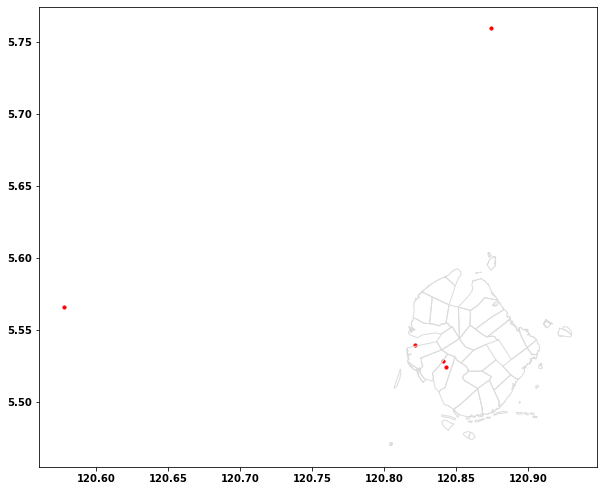

In [18]:
data = brgy_df[brgy_df['PSGC_MUNI']=='PH156612000']
feat = ['BRGY_SCHOOLS', 'brgy_area']
visualize_results(data, feat)

C:\Users\ROSIEL\anaconda3\lib\site-packages\ipykernel_launcher.py:22: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.


Cluster centers:
                    geometry
0  POINT (120.87310 5.58282)
1  POINT (120.78484 5.67256)
2  POINT (120.81519 5.57408)
3  POINT (120.88040 5.59852)
4  POINT (120.89233 5.58507)
Inertia: -0.000022
Silhouette score: 0.165407


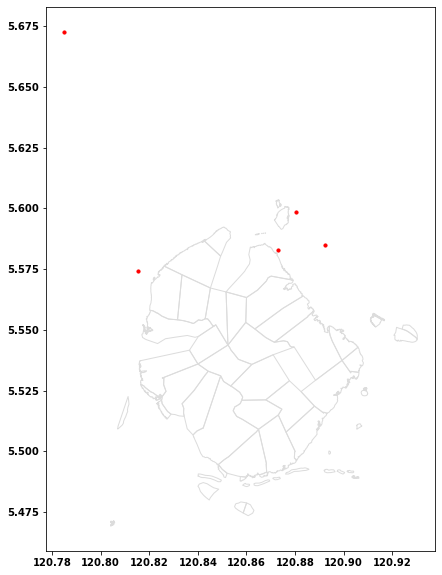

In [19]:
data = brgy_df[brgy_df['PSGC_MUNI']=='PH156612000']
feat = ['BRGY_SCHOOLS', 'Total_under10', 'Total_10to20']
visualize_results(data, feat)

Cluster centers:
                    geometry
0  POINT (120.83431 5.58544)
1  POINT (120.80648 5.57601)
2  POINT (120.81248 5.54875)
3  POINT (120.79664 5.66131)
4  POINT (120.82719 5.42254)
Inertia: -0.000022
Silhouette score: 0.202053


C:\Users\ROSIEL\anaconda3\lib\site-packages\ipykernel_launcher.py:22: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.


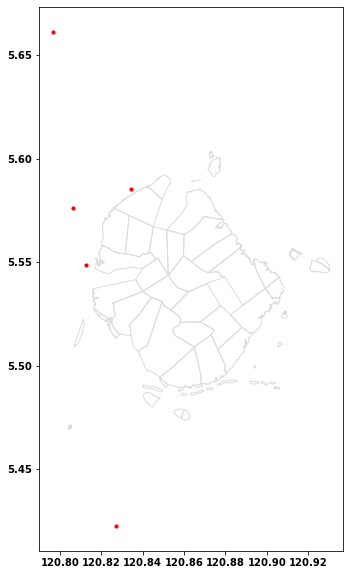

In [20]:
data = brgy_df[brgy_df['PSGC_MUNI']=='PH156612000']
feat = ['BRGY_SCHOOLS', 'brgy_area', 'Total_under10', 'Total_10to20', 'Total_31to60']
visualize_results(data, feat)

## DBSCAN Clustering using locations and multiple features

In [23]:
def preprocess_data_db(data, feat):
    """ Preprocessing of data
    1. Converting locations into radians
    2. Scaling dimensions of tabular features using PCA
    """
    
    locations = pd.DataFrame()
    locations['latitude'] = [radians(x) for x in data['latitude']]
    locations['longitude'] = [radians(x) for x in data['longitude']]

    features = scale(data[feat])
    
    return locations, features

def haversine_dist(x):
    """ Computing distance between two points on a sphere
    """
    return haversine_distances(x)

def euclidean_dist(x):
    """Computing Euclidean distance
    """
    return euclidean_distances(x)

def calculate_knn_distances(X, compute_dist):
    """Computes a distance matrix displaying pairwise distances between points
    """
    n = X.shape[0]
    knn_distances = np.zeros((n, n))
    
    for i in range(n):        
        for j in range(n):
            knn_distances[i, j] = compute_dist([X.iloc[i], X.iloc[j]])[0,1] 
            
    return knn_distances

def fit_dbscan(data, feat, eps, alpha, beta):
    locations, features = preprocess_data_db(data, feat)
    
    dist_matrix_loc = calculate_knn_distances(locations, haversine_dist)
    dist_matrix_feat = calculate_knn_distances(pd.DataFrame(features), euclidean_dist)

    dist_matrix = alpha * dist_matrix_loc
    dist_matrix += beta * dist_matrix_feat
    
    db = DBSCAN(eps=eps, min_samples=4)
    db.fit_predict(dist_matrix)
    labels = db.labels_
    
    return labels
    
def visualize_results_db(data, feat, eps, alpha, beta):
    locations, features = preprocess_data_db(data, feat)
    labels = fit_dbscan(data, feat, eps, alpha, beta)

    color_list = ['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'purple']
    color_vec = [color_list[label] for label in labels]

    plt.close()
    
    plt.figure(figsize=(10,10))
    ax = data['geometry'].plot(figsize=(10,10), color='none', 
                               edgecolor='gainsboro', zorder=3)
    plt.scatter(locations['latitude'], locations['longitude'], c=color_vec)
    plt.show()

<Figure size 720x720 with 0 Axes>

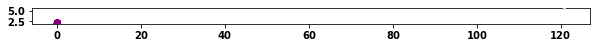

In [24]:
data = brgy_df[brgy_df['PSGC_MUNI']=='PH156612000']
feat = ['BRGY_SCHOOLS', 'brgy_area']
visualize_results_db(data, feat, eps=0.00025, alpha=2, beta=1)

In [ ]:
data = brgy_df[brgy_df['PSGC_MUNI']=='PH156612000']
feat = ['BRGY_SCHOOLS', 'Total_under10', 'Total_10to20']
visualize_results_db(data, feat, eps=0.00025, alpha=2, beta=1)

In [ ]:
data = brgy_df[brgy_df['PSGC_MUNI']=='PH156612000']
feat = ['BRGY_SCHOOLS', 'brgy_area', 'Total_under10', 'Total_10to20', 'Total_31to60']
visualize_results_db(data, feat, eps=0.00025, alpha=2, beta=1)